In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

In [4]:
df = pd.read_csv("../datasets/dataframe_for_preprocessing.csv")
df.head()

,Unnamed: 0,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,tcp,http,SF,181,5450,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,1,0,tcp,http,SF,239,486,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,2,0,tcp,http,SF,235,1337,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,3,0,tcp,http,SF,219,1337,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,4,0,tcp,http,SF,217,2032,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [5]:
df=df.drop('Unnamed: 0',axis=1)

In [6]:
df.drop_duplicates(inplace=True)
print(df.shape)

(145583, 41)


In [7]:
const_cols = [col for col in df.columns if df[col].min()==df[col].max()]
df.drop(columns = const_cols,inplace=True)

In [8]:
low_cardinality = ["protocol_type"]
medium_cardinality = ['flag']
high_cardinality = ['service']

In [9]:
def get_numerical(df):
    numerical_cols = []
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        if df[col].nunique(dropna=True) > 2:
            numerical_cols.append(col)
    return numerical_cols

def get_binary(df):
    binary_cols = []
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        if df[col].nunique(dropna=True) == 2:
            binary_cols.append(col)
    return binary_cols

def convert_to_folat(X):
    return X.astype(float)

In [10]:
numerical_cols = get_numerical(df)
binary_cols = get_binary(df)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
import category_encoders as ce

log_pipeline = Pipeline(
    steps=[
        ('to_float', FunctionTransformer(convert_to_folat, validate=False)),
        ('log', FunctionTransformer(np.log1p, validate=True)),
        ('scaler', RobustScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        
        ('num_log_scale', log_pipeline, numerical_cols),

        ('binary_pass','passthrough',binary_cols),
        ('low_ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
         low_cardinality),

        ('medium_ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
         medium_cardinality),

        ('high_binary', ce.BinaryEncoder(), high_cardinality)
    ],
    remainder='drop' 
)

In [12]:
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(df,test_size=0.2, random_state=42)

In [14]:
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

In [15]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_train_final)
distances, indices = neighbors_fit.kneighbors(X_train_final)

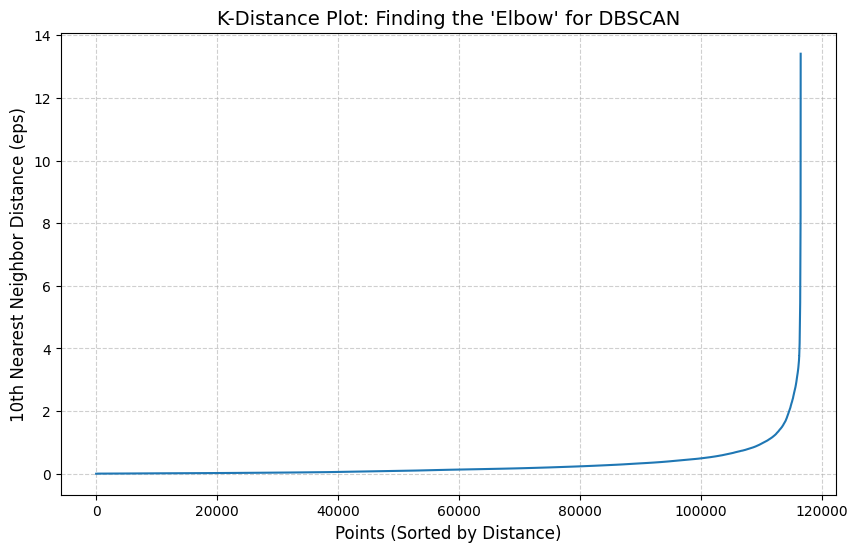

In [16]:
sorted_distances = np.sort(distances[:, 9], axis=0) # Index 9 is the 10th neighbor

plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title("K-Distance Plot: Finding the 'Elbow' for DBSCAN", fontsize=14)
plt.xlabel("Points (Sorted by Distance)", fontsize=12)
plt.ylabel("10th Nearest Neighbor Distance (eps)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)


plt.show()

In [ ]:
dbscan = DBSCAN(eps=1.80, min_samples=10)
db_labels = dbscan.fit_predict(X_train_final)